In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# latex style labels
plt.rcParams.update({"text.usetex": True,"font.family": "STIXGeneral"})#,"font.sans-serif": "Helvetica",})

## Histogram: Proportion of prompts per category

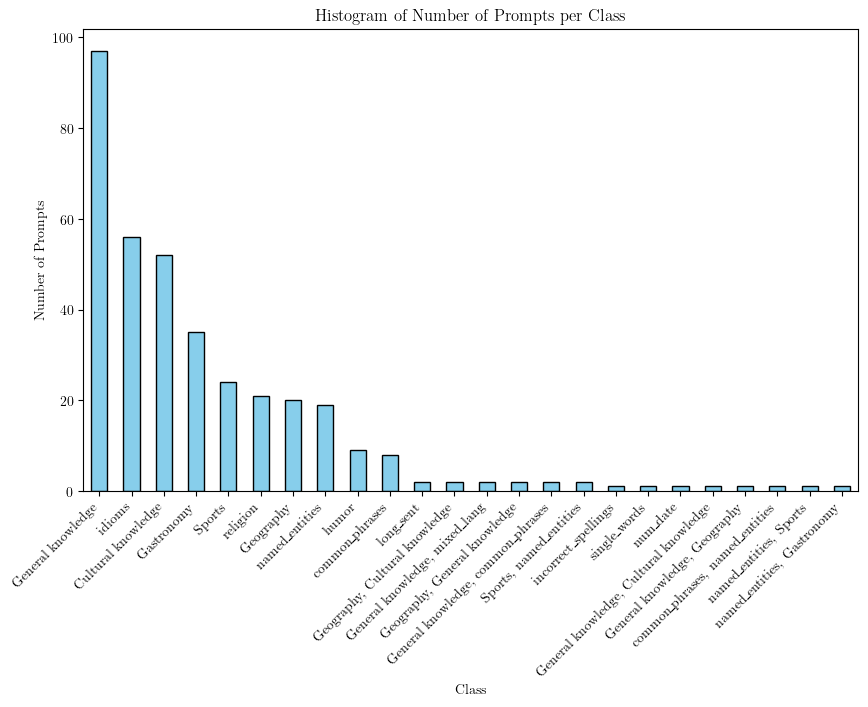

In [4]:
prompts_df = pd.read_csv('prompts.csv')
class_column = 'Domain'  # Change this to match your CSV file

# Count the number of prompts per class
class_counts = prompts_df[class_column].value_counts()

# Plot the histogram (bar chart)
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Number of Prompts')
plt.title('Histogram of Number of Prompts per Class')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [5]:
# Renaming the classes (for better understanding)
class_rename = {'named_entities': 'Name entities', 
                'common_phrases': 'Common phrases',
                'humor': 'Humor',
                'long_sent': 'Long sentences',
                'mixed_lang': 'Mixed language',
                'num_date': 'Dates',
                'single_words': 'Single word',
                'incorrect_spellings': 'Incorrect spelling' }

### Separating single class VS double class prompts

Total number of prompts plotted: 376


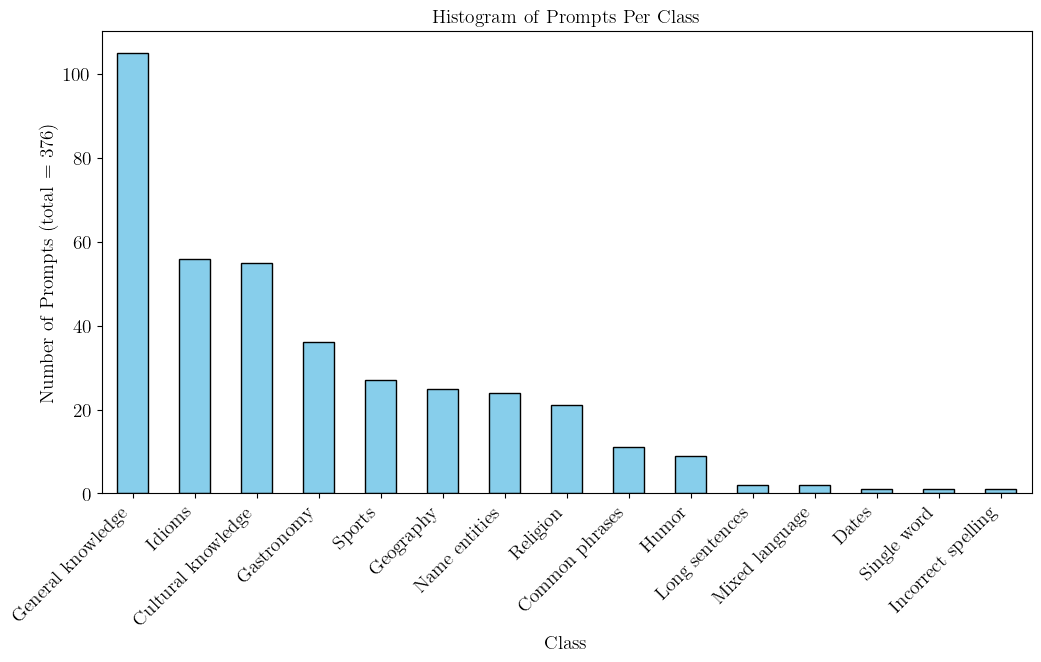

In [6]:
fontsize = 14

# Replace 'class_column' with the actual column name
class_column = 'Domain'  # Change this to the correct column name

# Split classes by comma
all_classes = prompts_df[class_column].dropna().str.split(', ').explode()
class_counts = all_classes.value_counts()
class_counts.index = [class_rename.get(c, c).capitalize() for c in class_counts.index]

total = class_counts.sum()
print("Total number of prompts plotted:", total)

# Plot histogram for individual class occurrences
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Class', fontsize=fontsize) 
plt.ylabel(f'Number of Prompts (total = {total})', fontsize=fontsize)
plt.title('Histogram of Prompts Per Class', fontsize=fontsize)
plt.xticks(rotation=45, ha='right', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig('figures/prompts_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

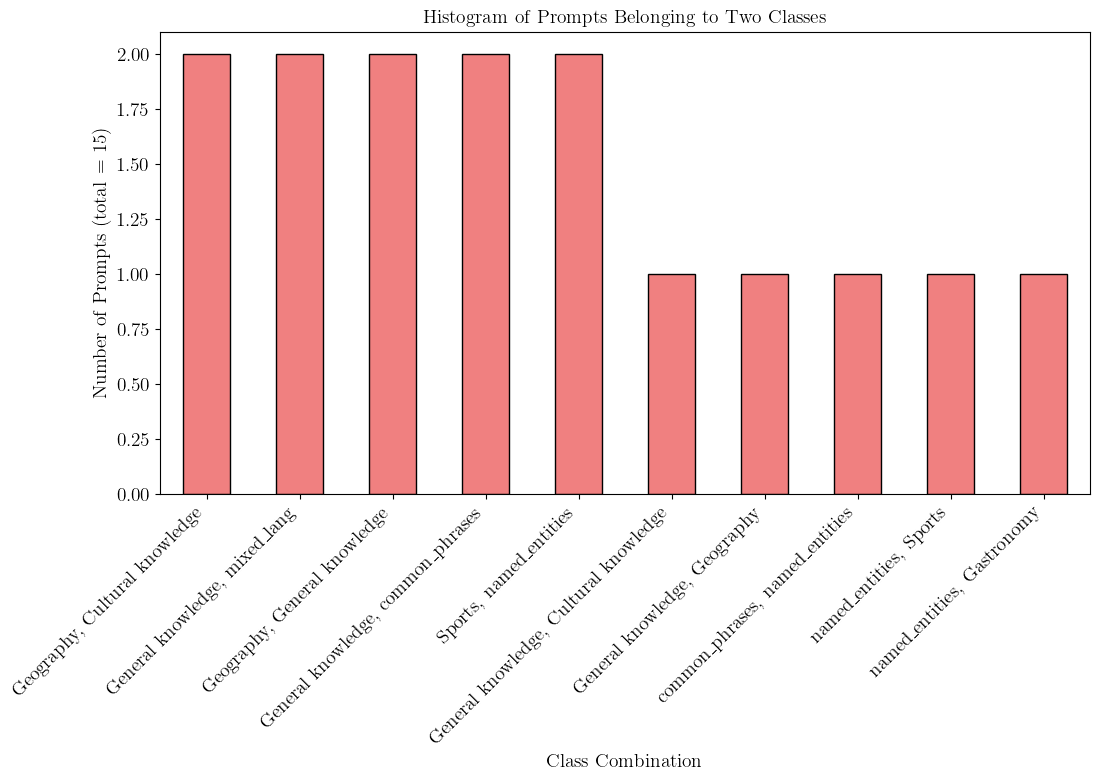

In [13]:
two_class_prompts = prompts_df[prompts_df[class_column].dropna().str.count(', ') == 1]

# Count occurrences of unique two-class combinations
two_class_counts = two_class_prompts[class_column].value_counts()

total_two_classes = two_class_counts.sum()
# Plot histogram for two-class combinations
plt.figure(figsize=(12, 6))
two_class_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('Class Combination', fontsize=fontsize) 
plt.ylabel(f'Number of Prompts (total = {total_two_classes})', fontsize=fontsize)
plt.title('Histogram of Prompts Belonging to Two Classes', fontsize=fontsize)
plt.xticks(rotation=45, ha='right', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig('figures/prompts_two_classes_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Leaderboard

In [7]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('database.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

In [8]:
# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('model',), ('vote',), ('sqlite_sequence',), ('votelog',)]


### Info about tables:
- **model**: has columns: name | upvote | downvote
- **vote**: has columns: id | username | model | vote | prompt | response | timestamp
- **sqlite_sequence**: has columns: name | seq
- **votelog**: has columns: id | username | chosen | rejected | prompt | chosen_response | rejected_response | is_tie | timestamp



In [4]:
# Query a table
cursor.execute("SELECT * FROM model;")
rows = cursor.fetchall()
for i, row in enumerate(rows):
    print(row)
    if i == 4:
        break


('Gemini-1.5-Pro', 26, 12)
('Meta-Llama-3-8B-Instruct', 0, 10)
('GPT-4o-Mini', 4, 4)
('Llama-3.3-70B-Instruct', 1, 8)
('Claude-3.5-Sonnet', 23, 17)


In [5]:
# Query a table
cursor.execute("SELECT * FROM vote;")
rows = cursor.fetchall()
for i, row in enumerate(rows):
    print(row)
    if i == 4:
        break

(1, 'cded00b2-ea10-4600-925c-4386a6f1d8a9', 'Gemini-1.5-Pro', 1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'الجمعة،  نهار الجمعة معروف بزاف بالكسكسو عند المغاربة.\n', '2024-12-29 00:53:25')
(2, 'cded00b2-ea10-4600-925c-4386a6f1d8a9', 'Meta-Llama-3-8B-Instruct', -1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'Hak! Ina nåra ya ʷan yagraw li ʷan wujud, masa ina gaw hakkin sqal bilaxox!Xi-ignore shwiya kiya kasemu kay affir,dhikras ya riwaq al maghribi kifa masa ina graw ya ʷan yagraw li yaddəl yu predeți yaxčan}=bessa ya ħaŧut                                                                            ', '2024-12-29 00:53:25')
(3, '85775de2-7b1b-4a50-98cb-8aa882708e03', 'GPT-4o-Mini', 1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'النهار المعروف اللي كياكلو فيه المغاربة كسكسو هو يوم الجمعة. كل جمعة، العائلات كتجمع وكتوجد الكسكسو، وكيكون واحد العادة بزاف عند المغاربة.', '2024-12-29 01:21:47')
(4, '85775de2-7b1b-4a50-98cb-8aa882708e03', 'Llama-3.3-70B-Instruct'

In [9]:
# Computing elo score: same function as get_leaderboard
def compute_elo_score(cursor):
    sql = '''
    SELECT name, 
           SUM(CASE WHEN vote = 1 THEN 1 ELSE 0 END) as upvote, 
           SUM(CASE WHEN vote = -1 THEN 1 ELSE 0 END) as downvote
    FROM model
    LEFT JOIN vote ON model.name = vote.model
    GROUP BY name
    '''
    
    print("Executing SQL query...")
    cursor.execute(sql)
    data = cursor.fetchall()
    df = pd.DataFrame(data, columns=['name', 'upvote', 'downvote'])
    df['votes'] = df['upvote'] + df['downvote']

    df['score'] = 1200  # Base ELO
    
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                expected_a = 1 / (1 + 10 ** ((df['score'].iloc[j] - df['score'].iloc[i]) / 400))
                expected_b = 1 / (1 + 10 ** ((df['score'].iloc[i] - df['score'].iloc[j]) / 400))
                actual_a = df['upvote'].iloc[i] / df['votes'].iloc[i] if df['votes'].iloc[i] > 0 else 0.5
                actual_b = df['upvote'].iloc[j] / df['votes'].iloc[j] if df['votes'].iloc[j] > 0 else 0.5
                df.iloc[i, df.columns.get_loc('score')] += 32 * (actual_a - expected_a)
                df.iloc[j, df.columns.get_loc('score')] += 32 * (actual_b - expected_b)

    df['score'] = round(df['score'])
    df = df.sort_values(by='score', ascending=False)
    df['order'] = ['#' + str(i+1) for i in range(len(df))]
    
    print(f"Returning final leaderboard data with {len(df)} models...")
    # Return only the columns we want to display
    return df[['order', 'name', 'score', 'votes']].values.tolist()

In [10]:
leaderboard = compute_elo_score(cursor)
leaderboard

Executing SQL query...
Returning final leaderboard data with 14 models...


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_56240/178643481.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1206.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('score')] += 32 * (actual_a - expected_a)


[['#1', 'ChatGPT-4o-Latest', 1274.0, 160],
 ['#2', 'GPT-4o', 1227.0, 14],
 ['#3', 'Claude-3.5-Sonnet', 1221.0, 156],
 ['#4', 'Gemini-1.5-Pro', 1178.0, 156],
 ['#5', 'GPT-4o-Mini', 1151.0, 8],
 ['#6', 'DeepSeek-V3', 1107.0, 81],
 ['#7', 'Llama-3.1-405B', 1032.0, 147],
 ['#8', 'Llama-3.1-Nemotron', 997.0, 47],
 ['#9', 'Grok-beta', 974.0, 155],
 ['#10', 'Llama-3.3-70B-Instruct', 932.0, 9],
 ['#11', 'Qwen2.5-72B-Instruct', 908.0, 9],
 ['#12', 'Meta-Llama-3-8B-Instruct', 871.0, 10],
 ['#13', 'QwQ-32B-Preview', 863.0, 10],
 ['#14', 'c4ai-command-r-plus-08-2024', 848.0, 8]]

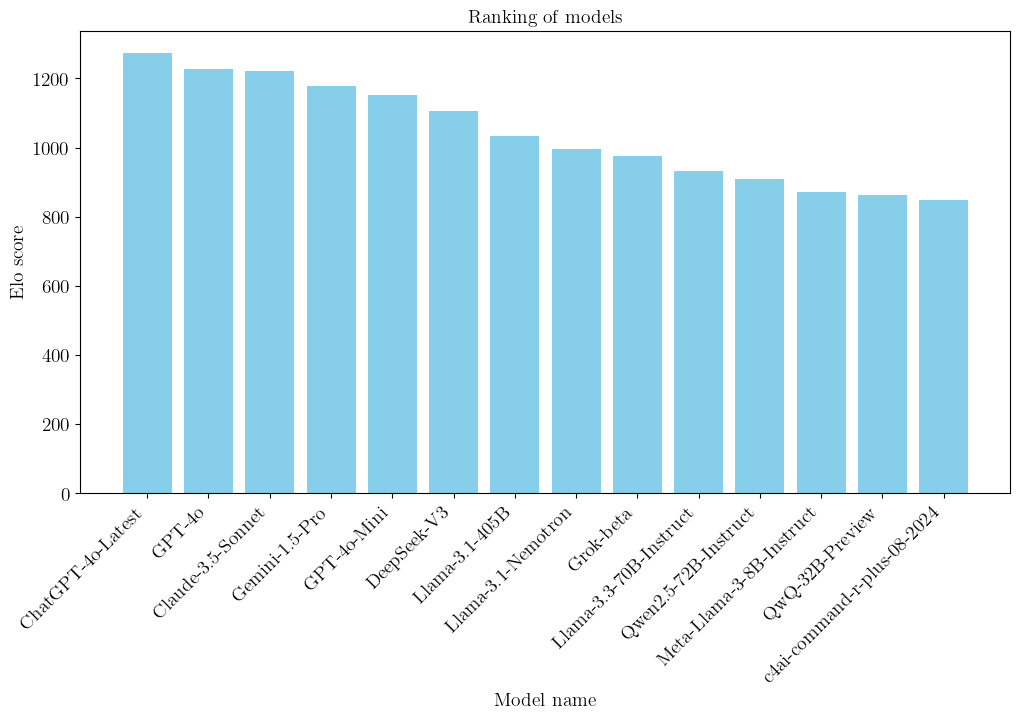

In [11]:
# Histogram
model_names = [item[1] for item in leaderboard]
scores = [item[2] for item in leaderboard]

# Plot histogram (bar chart)
plt.figure(figsize=(12, 6))
plt.bar(model_names, scores, color='skyblue')
plt.xlabel('Model name', fontsize=fontsize) 
plt.ylabel(f'Elo score', fontsize=fontsize)
plt.title('Ranking of models', fontsize=fontsize)
plt.xticks(rotation=45, ha='right', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig('figures/ranking.png', dpi=300, bbox_inches='tight')
plt.show()

### Win matrix

In [12]:
from collections import defaultdict

def predict_win_rate(leaderboard, SCALE=400, BASE=10, INIT_RATING=1000):
    names = [item[1] for item in leaderboard]
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    scores = [item[2] for item in leaderboard]

    for i,a in enumerate(names):
        for j, b in enumerate(names):
            #ea = 1 / (1 + BASE ** ((elo_ratings[b] - elo_ratings[a]) / SCALE))
            ea = 1 / (1 + BASE ** ((scores[j] - scores[i]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {
        a: [wins[a][b] if a != b else 1 for b in names]
        for a in names
    }

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

In [14]:
import plotly.express as px

win_rate = predict_win_rate(leaderboard)
ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
fig = px.imshow(win_rate.loc[ordered_models, ordered_models],
                color_continuous_scale='RdBu', text_auto=".2f",
                title="Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
fig.update_layout(xaxis_title="Model B",
                  yaxis_title="Model A",
                  xaxis_side="top", height=600, width=600,
                  title_y=0.07, title_x=0.5)
fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Win Rate: %{z}<extra></extra>")

fig.write_image("figures/win_rate_matrix.png")

## Percentage of won battles

In [24]:
# Query a table
cursor.execute("SELECT * FROM vote;")
rows = cursor.fetchall()
for i, row in enumerate(rows):
    print(row)
    if i == 6:
        break


(1, 'cded00b2-ea10-4600-925c-4386a6f1d8a9', 'Gemini-1.5-Pro', 1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'الجمعة،  نهار الجمعة معروف بزاف بالكسكسو عند المغاربة.\n', '2024-12-29 00:53:25')
(2, 'cded00b2-ea10-4600-925c-4386a6f1d8a9', 'Meta-Llama-3-8B-Instruct', -1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'Hak! Ina nåra ya ʷan yagraw li ʷan wujud, masa ina gaw hakkin sqal bilaxox!Xi-ignore shwiya kiya kasemu kay affir,dhikras ya riwaq al maghribi kifa masa ina graw ya ʷan yagraw li yaddəl yu predeți yaxčan}=bessa ya ħaŧut                                                                            ', '2024-12-29 00:53:25')
(3, '85775de2-7b1b-4a50-98cb-8aa882708e03', 'GPT-4o-Mini', 1, 'إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟', 'النهار المعروف اللي كياكلو فيه المغاربة كسكسو هو يوم الجمعة. كل جمعة، العائلات كتجمع وكتوجد الكسكسو، وكيكون واحد العادة بزاف عند المغاربة.', '2024-12-29 01:21:47')
(4, '85775de2-7b1b-4a50-98cb-8aa882708e03', 'Llama-3.3-70B-Instruct'

### There is a problem in vote table! sometimes the prompt is switched with the response column!

We can create a table containing the following coluns:
id | model_1 | model_2 | score_1 | score_2 | prompt | class

In [17]:
# Load the `vote` and `votelog` tables into DataFrames
vote_df = pd.read_sql_query("SELECT * FROM vote", conn)
votelog_df = pd.read_sql_query("SELECT * FROM votelog", conn)

In [18]:
vote_df

id                              username                     model  \
0      1  cded00b2-ea10-4600-925c-4386a6f1d8a9            Gemini-1.5-Pro   
1      2  cded00b2-ea10-4600-925c-4386a6f1d8a9  Meta-Llama-3-8B-Instruct   
2      3  85775de2-7b1b-4a50-98cb-8aa882708e03               GPT-4o-Mini   
3      4  85775de2-7b1b-4a50-98cb-8aa882708e03    Llama-3.3-70B-Instruct   
4      5  da371257-8f53-40cc-b0df-f89541038dfb         Claude-3.5-Sonnet   
..   ...                                   ...                       ...   
965  966  598d0059-5b16-47c5-b8fc-6ae5b3c9649e                 Grok-beta   
966  967  97aaf5d6-eaea-49b2-a90c-1d941407bcce            Gemini-1.5-Pro   
967  968  97aaf5d6-eaea-49b2-a90c-1d941407bcce               DeepSeek-V3   
968  969  8e9c68b1-e59e-42c0-a764-bd33e2710a67               DeepSeek-V3   
969  970  8e9c68b1-e59e-42c0-a764-bd33e2710a67            Llama-3.1-405B   

     vote                                             prompt  \
0       1  إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
1      -1  إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
2       1  إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
3      -1  إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
4      -1                                       وافين أعشيري   
..    ...                                                ...   
965    -1               بغيت نصاوب الشباكية، عطيني المقادير؟   
966     1  آش كايسميو المغاربة الجو فاش كاتكون الشتا و ال...   
967    -1  آش كايسميو المغاربة الجو فاش كاتكون الشتا و ال...   
968     1           علاش المغرب وقع معاهدة الحماية مع فرنسا؟   
969    -1           علاش المغرب وقع معاهدة الحماية مع فرنسا؟   

                                              response            timestamp  
0    الجمعة،  نهار الجمعة معروف بزاف بالكسكسو عند ا...  2024-12-29 00:53:25  
1    Hak! Ina nåra ya ʷan yagraw li ʷan wujud, masa...  2024-12-29 00:53:25  
2    النهار المعروف اللي كياكلو فيه المغاربة كسكسو ...  2024-12-29 01:21:47  
3    الجمعة. نهار الجمعة هو نهار الكسكس عند المغارب...  2024-12-29 01:21:47  
4    احلا و سهلا بيك خويا! لباس عليك؟ أنا الحمد لله...  2024-12-29 01:22:05  
..                                                 ...                  ...  
965  لا مشكل، هادي مقادير الشباكية المغربية:\n\n- *...  2025-02-06 09:21:26  
966  كاين اللي كيقولو "شمس الشتا" و كاين اللي كيقول...  2025-02-06 09:21:59  
967  المغاربة كايسمو هاد الجو "الشمس مع الشتا" ولا ...  2025-02-06 09:21:59  
968  المغرب وقع معاهدة الحماية مع فرنسا عام 1912، و...  2025-02-06 12:43:56  
969  المغرب وقع معاهدة الحماية مع فرنسا عام 1912، ب...  2025-02-06 12:43:56  

[970 rows x 7 columns]

In [19]:
prompts_df = pd.read_csv('prompts.csv')

In [20]:
# Example: Assuming Vote is already loaded as a DataFrame
# The structure of Vote as described: id, username, model, vote, prompt, response, timestamp

# Select every two consecutive rows (pairing them as battles)
battles = vote_df.iloc[::2].reset_index(drop=True)  # Rows for model_1
battles["model_2"] = vote_df.iloc[1::2]["model"].reset_index(drop=True)  # Add model_2
battles["score_2"] = vote_df.iloc[1::2]["vote"].reset_index(drop=True)  # Add score_2
battles["score_1"] = battles["vote"]  # score_1 is the vote of model_1
battles = battles.drop(columns=["vote"])  # Drop the redundant 'vote' column

# Rename and organize columns
battles = battles.rename(columns={"model": "model_1"})
battles = battles[["username", "model_1", "model_2", "score_1", "score_2", "prompt"]]

# Merge with Prompts DataFrame to add the 'class' column
# Assuming Prompts has columns ['prompt', 'Domain'] and needs to map 'Domain' to 'class'
battles = battles.merge(prompts_df.rename(columns={"Domain": "class", "Prompt": "prompt"}), on="prompt", how="left")

# Display the final DataFrame
battles


username            model_1  \
0    cded00b2-ea10-4600-925c-4386a6f1d8a9     Gemini-1.5-Pro   
1    85775de2-7b1b-4a50-98cb-8aa882708e03        GPT-4o-Mini   
2    da371257-8f53-40cc-b0df-f89541038dfb  Claude-3.5-Sonnet   
3    665fd55d-ab80-4694-b95b-e412d446200e  Claude-3.5-Sonnet   
4    ae0e8204-bee8-48be-8704-eec4729071b7     Llama-3.1-405B   
..                                    ...                ...   
483  2e537499-84bc-4c2c-a633-8ca365021ee5     Gemini-1.5-Pro   
484  13044ff7-dc7d-4036-bd23-77e3125b8615  ChatGPT-4o-Latest   
485  598d0059-5b16-47c5-b8fc-6ae5b3c9649e  ChatGPT-4o-Latest   
486  97aaf5d6-eaea-49b2-a90c-1d941407bcce     Gemini-1.5-Pro   
487  8e9c68b1-e59e-42c0-a764-bd33e2710a67        DeepSeek-V3   

                         model_2  score_1  score_2  \
0       Meta-Llama-3-8B-Instruct        1       -1   
1         Llama-3.3-70B-Instruct        1       -1   
2    c4ai-command-r-plus-08-2024       -1       -1   
3         Llama-3.3-70B-Instruct        1       -1   
4       Meta-Llama-3-8B-Instruct       -1       -1   
..                           ...      ...      ...   
483                    Grok-beta        1       -1   
484                  DeepSeek-V3        1       -1   
485                    Grok-beta        1       -1   
486                  DeepSeek-V3        1       -1   
487               Llama-3.1-405B        1       -1   

                                                prompt  \
0    إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
1    إينا نهار لي معروف عل المغاربة كاياكلو فيه كسكسو؟   
2                                         وافين أعشيري   
3    زيد نلعبو شتي الديب، أنشرح ليك كيفاش تلعب معاي...   
4                                  عطيني شي نكتة كاضحك   
..                                                 ...   
483                            شكون هو El Grande Toto?   
484                                     شنهيا التقلية؟   
485               بغيت نصاوب الشباكية، عطيني المقادير؟   
486  آش كايسميو المغاربة الجو فاش كاتكون الشتا و ال...   
487           علاش المغرب وقع معاهدة الحماية مع فرنسا؟   

                             class  batch              person  
0                         num_date    1.0                 NaN  
1                         num_date    1.0                 NaN  
2                   common_phrases    1.0                 NaN  
3                            humor    1.0                 NaN  
4                            humor    1.0                 NaN  
..                             ...    ...                 ...  
483  General knowledge, mixed_lang    2.0  aymane elfirdoussi  
484                     Gastronomy    2.0       Imane Momayiz  
485     named_entities, Gastronomy    2.0    Ihssane Nedjaoui  
486                         idioms    2.0  aymane elfirdoussi  
487              General knowledge    2.0  aymane elfirdoussi  

[488 rows x 9 columns]

In [22]:
# battles = battles.drop('Unnamed: 3', axis = 1)
# battles.head(5)

In [23]:
battles.to_csv('battles.csv', index= False)

In [12]:
import sqlite3

# Connect to the database
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# Query to get unique names in a column
column_name = "chosen"  # Replace with your column name
table_name = "votelog"  # Replace with your table name
query = f"SELECT DISTINCT {column_name} FROM {table_name}"

cursor.execute(query)
unique_names = cursor.fetchall()

# Print the results
for name in unique_names:
    print(name[0])

# Close the connection
#conn.close()

Gemini-1.5-Pro
GPT-4o-Mini
Claude-3.5-Sonnet
Llama-3.1-405B
Llama-3.3-70B-Instruct
Llama-3.1-Nemotron
GPT-4o
ChatGPT-4o-Latest
Grok-beta
QwQ-32B-Preview
c4ai-command-r-plus-08-2024
Qwen2.5-72B-Instruct
claude_3_5_sonnet_20240620


In [13]:
def rename_model(conn, cursor, table, column, old_name='claude_3_5_sonnet_20240620', new_name='Claude-3.5-Sonnet'):
    # Check if the model with the old name exists
    cursor.execute(f"SELECT COUNT(*) FROM {table} WHERE {column} = ?", (old_name,))
    count = cursor.fetchone()[0]

    if count > 0:
        # Update the model name
        cursor.execute(f"UPDATE {table} SET {column} = ? WHERE {column} = ?", (new_name, old_name))
        print(f"Renamed {count} row(s) from '{old_name}' to '{new_name}'")
    else:
        print(f"Model '{old_name}' not found, no renaming performed.")

    # Commit the changes and close the connection
    conn.commit()

In [21]:
# Query to get unique names in a column
column = "rejected"  # Replace with your column name
table = "votelog"  # Replace with your table name
rename_model(conn, cursor, table, column)

query = f"SELECT DISTINCT {column} FROM {table}"

cursor.execute(query)
unique_names = cursor.fetchall()

# Print the results
for name in unique_names:
    print(name[0])

Renamed 2 row(s) from 'claude_3_5_sonnet_20240620' to 'Claude-3.5-Sonnet'
Meta-Llama-3-8B-Instruct
Llama-3.3-70B-Instruct
c4ai-command-r-plus-08-2024
Llama-3.1-405B
QwQ-32B-Preview
GPT-4o-Mini
Qwen2.5-72B-Instruct
Claude-3.5-Sonnet
Llama-3.1-Nemotron
Grok-beta
ChatGPT-4o-Latest
GPT-4o
Gemini-1.5-Pro


In [6]:
import csv
import json

csv_file = 'prompts.csv'  # Replace with your CSV file name
json_file = 'prompts.json'  # Replace with the desired output file name

# Open CSV and JSON files
with open(csv_file, 'r') as csvfile, open(json_file, 'w') as jsonfile:
    # Read CSV data
    reader = csv.DictReader(csvfile)
    
    # Convert rows to JSON and save
    json.dump(list(reader), jsonfile, indent=4)

print(f"CSV file converted to JSON and saved as {json_file}")


CSV file converted to JSON and saved as prompts.json


In [7]:
import json

# Path to your JSON file
json_file = 'prompts.json'

# Open and read the file
with open(json_file, 'r') as file:
    data = json.load(file)  # Load JSON data as a Python dictionary or list

# Print or access the data
print(data[:2])


[{'Prompt': 'منلقاش عندك شي زرقة', 'Domain': 'humor', 'batch': '1', 'person': ''}, {'Prompt': 'وافين أعشيري', 'Domain': 'common_phrases', 'batch': '1', 'person': ''}]


In [14]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('database.db')  # Replace 'your_database.db' with your actual database file
cursor = conn.cursor()

# Query to fetch name, upvote, and downvote
query = "SELECT name, upvote, downvote FROM model"
cursor.execute(query)

# Create the dictionary
result = {row[0]: row[1] + row[2] for row in cursor.fetchall()}

# Close the connection
conn.close()

# Print the resulting dictionary
print(result)


{'Gemini-1.5-Pro': 38, 'Meta-Llama-3-8B-Instruct': 10, 'GPT-4o-Mini': 8, 'Llama-3.3-70B-Instruct': 9, 'Claude-3.5-Sonnet': 40, 'c4ai-command-r-plus-08-2024': 8, 'Llama-3.1-405B': 24, 'QwQ-32B-Preview': 10, 'Llama-3.1-Nemotron': 19, 'Qwen2.5-72B-Instruct': 9, 'Grok-beta': 41, 'GPT-4o': 14, 'ChatGPT-4o-Latest': 31}


In [15]:
import numpy as np

# Step 1: Compute weights inversely proportional to votes
epsilon = 1e-6  # Small value to avoid division by zero
weights = {name: 1 / (result[name] + epsilon) for name in result}
#weights = {name: np.exp(-result[name]) for name in result}
# Step 2: Normalize weights to get probabilities
total_weight = sum(weights.values())
probabilities = {name: weight / total_weight for name, weight in weights.items()}

print(probabilities)
# Step 3: Sample two names using a multinomial distribution
names = list(probabilities.keys())
probs = list(probabilities.values())
sampled_names = np.random.choice(names, size=2, replace=False, p=probs)

print("Sampled names:", sampled_names)

{'Gemini-1.5-Pro': 0.027820515657962102, 'Meta-Llama-3-8B-Instruct': 0.10571795171051238, 'GPT-4o-Mini': 0.1321474363344549, 'Llama-3.3-70B-Instruct': 0.11746438948429845, 'Claude-3.5-Sonnet': 0.026429489909839638, 'c4ai-command-r-plus-08-2024': 0.1321474363344549, 'Llama-3.1-405B': 0.044049149115580256, 'QwQ-32B-Preview': 0.10571795171051238, 'Llama-3.1-Nemotron': 0.055641029851686605, 'Qwen2.5-72B-Instruct': 0.11746438948429845, 'Grok-beta': 0.02578486822044408, 'GPT-4o': 0.07551282480787505, 'ChatGPT-4o-Latest': 0.0341025673780809}
Sampled names: ['GPT-4o' 'GPT-4o-Mini']


In [24]:
import pandas as pd 
df = pd.read_csv('responses.csv')
# Drop prompts that only appear once because we can't compare them
prompt_counts = df['prompt'].value_counts()
df = df[df['prompt'].isin(prompt_counts[prompt_counts > 1].index)]
df

prompt  \
0                                   آش كاتعني "ولد مو"؟   
1                                   آش كاتعني "ولد مو"؟   
2                                   آش كاتعني "ولد مو"؟   
3                                   آش كاتعني "ولد مو"؟   
4                                   آش كاتعني "ولد مو"؟   
...                                                 ...   
1503  يالاه دخلت ل لاصال، عطيني شي بروغرام ناضي باش ...   
1504  يالاه دخلت ل لاصال، عطيني شي بروغرام ناضي باش ...   
1505  يالاه دخلت ل لاصال، عطيني شي بروغرام ناضي باش ...   
1506  يالاه دخلت ل لاصال، عطيني شي بروغرام ناضي باش ...   
1507  يالاه دخلت ل لاصال، عطيني شي بروغرام ناضي باش ...   

                                               response         model_name  
0     "ولد مو" فالدارجة المغربية كاتعني الولد ديال ا...  ChatGPT-4o-Latest  
1     "ولد مو" كاتعني "ولد الله" أو "عبد الله". هاد ...          Grok-beta  
2     "ولد مو" هي عبارة دارجة مغربية كتستعمل لوصف شي...     Llama-3.1-405B  
3     كاتعني ولد الناس،  واحد محترم و عندو مبادئ.  ك...     Gemini-1.5-Pro  
4     "ولد مو" هي سبة مغربية كيستعملوها ناس بزاف للت...  Claude-3.5-Sonnet  
...                                                 ...                ...  
1503  واااااااااا الغولي، واخا خويا، غادي نعطيك واحد...  ChatGPT-4o-Latest  
1504  واش كتبغي بروغرام ناضي باش تولي كي الغول؟ خلين...          Grok-beta  
1505  ماشي مشكل، هادي بروغرام ناضي ليك:\n\n**السبت**...     Llama-3.1-405B  
1506  واخا صاحبي! دخلتي للاصال باغا تولي غول؟ هانتا ...     Gemini-1.5-Pro  
1507  مرحبا بيك فلاصال! هادي برنامج مزيان باش تبدا:\...  Claude-3.5-Sonnet  

[1508 rows x 3 columns]

In [28]:

prompt = df['prompt'][200]
prompt_responses = df[df['prompt'] == prompt]
print(prompt_responses['model_name'])
sampled_names = np.random.choice(names, size=2, replace=False, p=probs)
print(sampled_names)
#selected_responses = prompt_responses[prompt_responses['model_name'].isin(sampled_names)]
selected_responses = prompt_responses[prompt_responses['model_name'].isin(sampled_names)]
#print(selected_responses)

196    ChatGPT-4o-Latest
197            Grok-beta
198       Llama-3.1-405B
199       Gemini-1.5-Pro
200    Claude-3.5-Sonnet
Name: model_name, dtype: object
['Claude-3.5-Sonnet' 'QwQ-32B-Preview']


## New win matrix

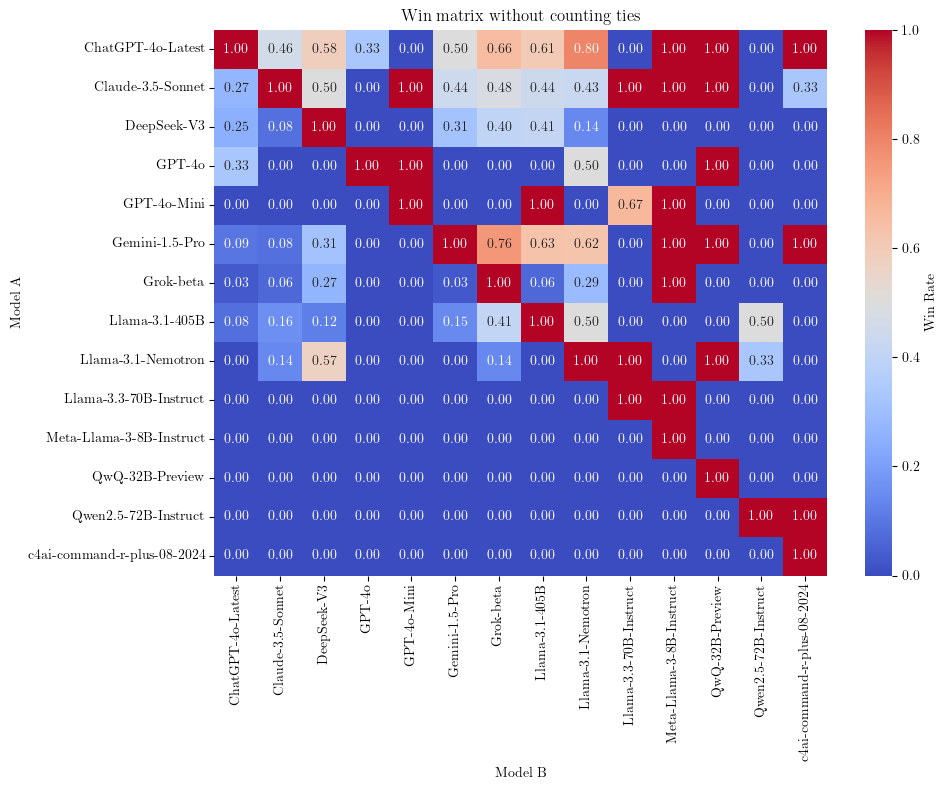

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('battles.csv')

# Initialize an empty dictionary to store win/loss data
win_counts = {}

# Iterate through the dataset
for _, row in df.iterrows():
    model_1, model_2 = row['model_1'], row['model_2']
    score_1, score_2 = row['score_1'], row['score_2']
    
    # Initialize win/loss records for models if not already present
    if model_1 not in win_counts:
        win_counts[model_1] = {}
    if model_2 not in win_counts:
        win_counts[model_2] = {}

    # Record the outcome for model_1 vs model_2
    if model_2 not in win_counts[model_1]:
        win_counts[model_1][model_2] = [0, 0]  # [wins, games]
    if model_1 not in win_counts[model_2]:
        win_counts[model_2][model_1] = [0, 0]  # [wins, games]

    # Update win/loss counts
    if score_1 == 1 and score_2 == -1:  # model_1 wins
        win_counts[model_1][model_2][0] += 1
    elif score_1 == -1 and score_2 == 1:  # model_2 wins
        win_counts[model_2][model_1][0] += 1
    
    # Increment games played for both directions
    win_counts[model_1][model_2][1] += 1
    win_counts[model_2][model_1][1] += 1

# Create a sorted list of models
models = sorted(win_counts.keys())

# Initialize the win-rate matrix
win_rate_matrix = pd.DataFrame(0, index=models, columns=models, dtype=float)

# Populate the win-rate matrix
for model_1 in models:
    for model_2 in models:
        if model_1 == model_2:
            win_rate_matrix.loc[model_1, model_2] = 1.0
        elif model_2 in win_counts[model_1]:
            wins, games = win_counts[model_1][model_2]
            win_rate_matrix.loc[model_1, model_2] = wins / games if games > 0 else 0

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(win_rate_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Win Rate'})
plt.title('Win matrix without counting ties')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.tight_layout()

plt.savefig('figures/win_rate_matrix_no_tie.png', dpi=300, bbox_inches='tight')
plt.show()

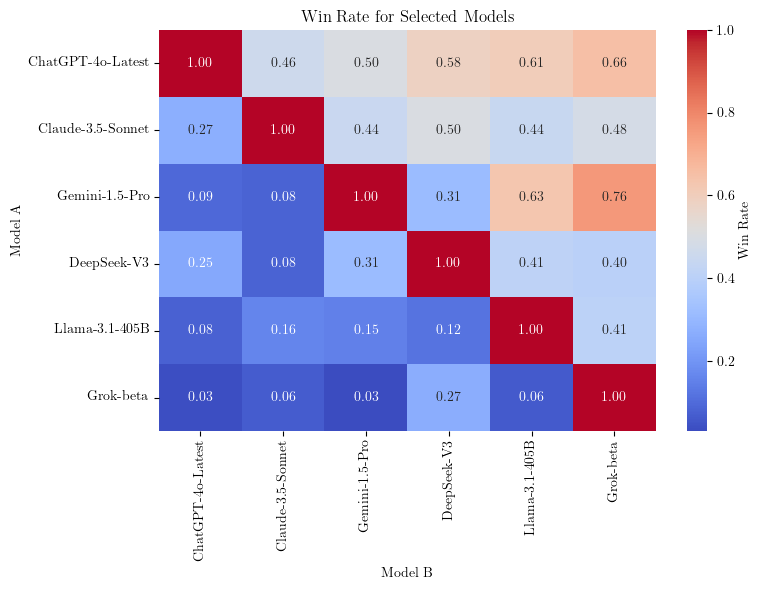

In [ ]:
# Define a list of specific models to include in the plot
selected_models = ['ChatGPT-4o-Latest', 'Claude-3.5-Sonnet', 'Gemini-1.5-Pro', 'DeepSeek-V3', 'Llama-3.1-405B', 'Grok-beta']

# Filter the win_rate_matrix to include only the selected models
filtered_win_rate_matrix = win_rate_matrix.loc[selected_models, selected_models]

# Plot the heatmap for the selected models
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_win_rate_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Win Rate'})
plt.title('Win Rate for Selected Models')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.tight_layout()

# Save the filtered figure
plt.savefig('figures/filtered_win_rate.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Win matrix by counting ties with a score: $\pm$ 0.5

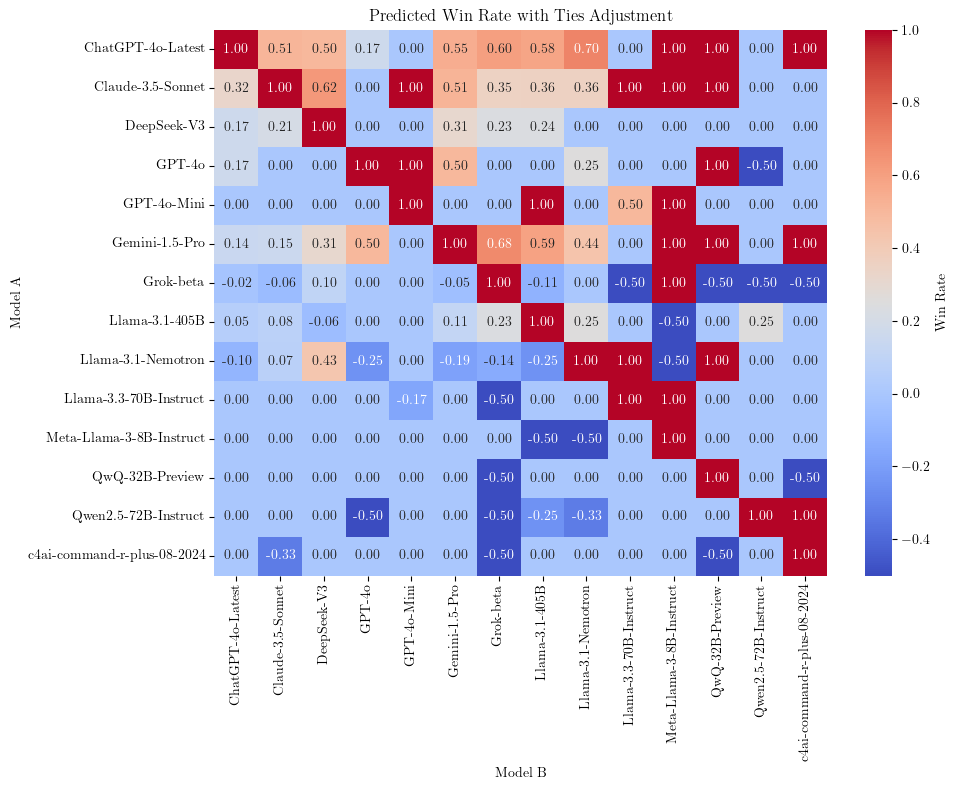

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with the actual filename)
df = pd.read_csv('battles.csv')

# Initialize an empty dictionary to store win/loss/tie data
win_counts = {}
tie_score = 0.5
# Iterate through the dataset
for _, row in df.iterrows():
    model_1, model_2 = row['model_1'], row['model_2']
    score_1, score_2 = row['score_1'], row['score_2']
    
    # Initialize win/loss records for models if not already present
    if model_1 not in win_counts:
        win_counts[model_1] = {}
    if model_2 not in win_counts:
        win_counts[model_2] = {}

    # Record the outcome for model_1 vs model_2
    if model_2 not in win_counts[model_1]:
        win_counts[model_1][model_2] = [0, 0]  # [wins, games]
    if model_1 not in win_counts[model_2]:
        win_counts[model_2][model_1] = [0, 0]  # [wins, games]

    # Update win/loss/tie counts
    if score_1 == 1 and score_2 == -1:  # model_1 wins
        win_counts[model_1][model_2][0] += 1
    elif score_1 == -1 and score_2 == 1:  # model_2 wins
        win_counts[model_2][model_1][0] += 1
    elif score_1 == 1 and score_2 == 1:  # Both win (tie)
        win_counts[model_1][model_2][0] += tie_score  # Increase by 0.5
        win_counts[model_2][model_1][0] += tie_score  # Increase by 0.5
    elif score_1 == -1 and score_2 == -1:  # Both lose (tie)
        win_counts[model_1][model_2][0] -= tie_score  # Decrease by 0.5
        win_counts[model_2][model_1][0] -= tie_score  # Decrease by 0.5

    # Increment games played for both directions
    win_counts[model_1][model_2][1] += 1
    win_counts[model_2][model_1][1] += 1

# Create a sorted list of models
models = sorted(win_counts.keys())

# Initialize the win-rate matrix
win_rate_matrix = pd.DataFrame(0, index=models, columns=models, dtype=float)

# Populate the win-rate matrix
for model_1 in models:
    for model_2 in models:
        if model_1 == model_2:
            win_rate_matrix.loc[model_1, model_2] = 1.0
        elif model_2 in win_counts[model_1]:
            wins, games = win_counts[model_1][model_2]
            win_rate_matrix.loc[model_1, model_2] = wins / games if games > 0 else 0

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(win_rate_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Win Rate'})
plt.title('Predicted Win Rate with Ties Adjustment')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.tight_layout()

# Save the figure
plt.savefig('win_rate_with_ties.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
